# Physics NeMo External Aerodynamics DLI

## Training DoMINO Model on the Ahmed body surface dataset

In this notebook, we will first provide a detailed explanation of the DoMINO architecture, which is a multi-scale, iterative neural operator designed for modeling large-scale engineering simulations. We will break down the key components of DoMINO, including its use of local geometry representations, multi-scale point convolution kernels, and its efficient handling of complex geometries. Afterward, we will train the model using the **Ahmed body surface dataset**, a widely used dataset in automotive aerodynamics simulations. *As indicated in the previous notebook this dataset was created by the NVIDIA Physics NeMo development team and differs from other similar datasets hosted on cloud platforms like AWS.*

*The DoMINO model is capable of training both volume fields (such as velocity and pressure) and surface fields (including pressure and wall shear stress). However, for the sake of simplicity and educational purposes, this notebook will *focus solely on training the surface fields* using the Ahmed body surface dataset.*

## Guid line
- Before starting training, ensure GPU memory is cleared by running:
```python
import os
os._exit(00)
```
- DLI_01 should be run beforehand as a prerequisite to prepare the data in NPY format.
- The amount of GPU memory allocated during training can be controlled through the following configuration parameters:
```yaml
  interp_res=GRID_RESOLUTION # Resolution of the latent space; coarser resolutions reduce memory usage.
  NUM_SURFACE_NEIGHBORS = 7  # Number of neighboring surface points used to compute solution variables such as pressure. 
  SURFACE_POINTS_SAMPLE = 8192  # Number of surface points sampled per epoch; fewer points reduce memory consumption
```
    To adjust GPU memory usage, modify the above configuration values in the "Experiment Parameters and Variables" section.


## Table of Contents
- [DoMINO Architecture](#domino-architecture)
  - [Global Geometry Representation](#global-geometry-representation)
  - [Local Geometry Representation](#local-geometry-representation)
  - [Basis Function Neural Network](#basis-function-neural-network)
  - [Concatenating the Latent Vector with the Local Geometry Encoding](#concatenating-the-latent-vector-with-the-local-geometry-encoding)
  - [Passing Through Additional Neural Network Layers](#passing-through-additional-neural-network-layers)
  - [Aggregation Network](#aggregation-network)
- [Training Process](#training)
  - [Step 1: Define Experiment Parameters and Dependencies](#step-1-define-experiment-parameters-and-dependencies)
    - [Loading Required Libraries](#loading-required-libraries)
    - [Dependencies](#dependencies)
    - [Experiment Parameters and Variables](#experiment-parameters-and-variables)
  - [Step 2: Train the DoMINO Model](#step-2-train-the-domino-model)
    - [Understanding the Training Process](#understanding-the-training-process)
    - [Key Components and Libraries](#key-components-and-libraries)
    - [Important Training Parameters](#important-training-parameters)
    - [Implementation Overview](#implementation-overview)
- [Load Model Checkpoint & Run Inference](#Load-Model-Checkpoint-&-Run-Inference)
- [Visualizing the predicted results](#Visualizing-the-predicted-results)


## DoMINO Architecture
Machine learning (ML) models have been proposed as surrogate models to speed up simulations, but they face limitations, particularly in terms of accuracy, scalability, and generalization to new geometries.
DoMINO, a new ML model designed to address these challenges. DoMINO is a multi-scale, iterative neural operator that uses local geometric information to predict flow fields in large-scale simulations. It is specifically validated for the automotive aerodynamics use case, showcasing its scalability, accuracy, and ability to generalize across different simulation scenarios. Let's walk through the DoMINO architecture step by step, starting from the *Global Geometry Representation, through to the Local Geometry Representation, and then to the Aggregation Network.*

The DoMINO model evaluates solution fields within a computational domain by leveraging geometry representations in STL file format. It encodes global geometry information on a fixed-size grid, defined in the computational domain, through a combination of learnable point convolution kernels, CNNs, and dense networks. Local geometric encoding is extracted, using point convolution kernels, from the global encoding by dynamically constructing local subdomains around sampled points where the solution fields are evaluated. This approach enables the prediction of volume and surface solutions by combining local geometry encoding with basis functions computed for sampled points and their neighboring points.

### Global Geometry Representation:
The Global Geometry Representation refers to the overall shape and structure of the entire object or domain that you are modeling. This representation captures all the geometric details across the entire computational domain.\
Step-by-Step Explanation of Global Geometry Representation:

- **Step 1**: Construct Bounding Boxes
	- A tight-fitting surface bounding box is created around the STL (3D geometry) to hold the geometry.
    - A computational domain bounding box is also defined, which is larger than the surface bounding box to encompass the whole computational domain.
    - Both bounding boxex can be specified in  ```conf.yaml```
- **Step 2**: Project STL Vertices onto Structured Grid
	- The geometric features of the point cloud, such as spatial coordinates, are projected onto an N-dimensional structured grid of resolution m×m×m×f, which is overlaid on the surface bounding box using **learnable point convolution kernels**.
	- The learnable point convolution kernels are created using **differentiable ball query layers**. This means that the method:
    	- Uses a "ball" (a sphere in 3D space) around each point to query or find its neighbors.
    	- The ball query layer is "differentiable," meaning it can be included in the neural network and updated via backpropagation (i.e., during training, the network can learn how to adjust the kernels to improve performance).
    	- The radius of the ball (radius of influence) defines how far around each point we look for neighboring points to include in the convolution. This defines, in fact, how far the geometry can affect the grid. A range of point convolutional kernel sizes can be learned by specifying several radii. Moreover, different kernels are learned to represent information on the surface bounding box and computational domain bounding box. This enables multi-scale learning of geometry encoding by representing both short- and long-range interactions of the surface and flow fields.  The radii of influence are defined as **list** in the ```conf.yaml``` file:
          ```yaml
            volume_radii: [0.1, 0.5]
            surface_radii: [0.05]
          ```
\
          These radius are used in the DoMINO model (```physicsnemo/models/domino/model.py```) to compute two **BQWarp** accordingly:
          

     
```python
        class GeometryRep(nn.Module):
            """Geometry representation from STLs block"""

            def __init__(self, input_features, model_parameters=None):
                super().__init__()
                geometry_rep = model_parameters.geometry_rep

                self.bq_warp = nn.ModuleList()
                self.geo_processors = nn.ModuleList()
                for j, p in enumerate(radii):
                    self.bq_warp.append(
                        BQWarp(
                            input_features=input_features,
                            grid_resolution=model_parameters.interp_res,
                            radius=radii[j],
                        )
                    )
                    self.geo_processors.append(
                        GeoProcessor(
                            input_filters=geometry_rep.geo_conv.base_neurons_out,
                            model_parameters=geometry_rep.geo_processor,
                        )
                    )
```
       
        
- **Step 3**: Use Multi-Resolution Approach for Detailed and Coarse Features
	- The grid resolution in the bounding box determines the level of detail of the geometry: 
    	- Finer resolution captures more detailed features of the geometry.
    	- Coarser resolution captures larger, broader features.
	- A multi-resolution approach is adopted, meaning multiple grids at different resolutions (levels) are maintained to capture both fine and coarse features of the geometry. The number of resolution levels is a parameter that can be adjusted in conf.yaml file as
      ```yaml
      GRID_RESOLUTION = [128, 64, 48]  # Resolution of the interpolation grid 
      ```
  - Currently, the DoMINO model allows specification of a single resolution but this configuration will be provided in a future release.

- **Step 4**: Propagate Geometry Features into the Computational Domain
  - The computational domain is much larger than the surface bounding box, so the geometry information needs to be extended.
	- Geometry features are propagated into the computational domain using two methods: 
    	- As explained in **step 2** Multi-scale **point convolution kernels** project the **geometry information** onto the surface bounding box (**see below the letf figure**).
    	- **Features** from the surface grid of the bounding box (i.e., Gs) are propagated into the computational domain grid (i.e., Gc) using **CNN blocks** that contain convolution, pooling, and unpooling layers (**see below the letf figure**).
          As you see in the cvode snipet above first `BQWarp` is calculated and then  CNN blocks using `GeoProcessor`:
          ```python
          class GeoProcessor(nn.Module):
          ```
	- The **CNN blocks are iterated** for a specified number of steps to refine the geometry representation. Currently, the DoMINO model is configured to run a single iteration. An option to change this will be provided in ```conf.yaml``` in a future release.

- **Step 5**: Calculate Signed Distance Function (SDF) and its Gradients
	- Additionally, the Signed Distance Function (SDF) and its gradient components are calculated on the computational domain grid.
	- These SDF and gradient values are added to the learned features, providing additional information about the topology of the geometry (i.e., the geometry's shape, distances to surfaces, etc.).

- **Step 6**: Final Global Geometry Representation
	- The final geometry representation of the STL is formed by combining the learned features from the structured grids at different resolutions in both the bounding box and the computational domain.

Once the computational domain is created for each resolution, the next step would be local geometry representation. 

### Local geometry representation
The Local Geometry Representation focuses on the geometry in the immediate vicinity of a sampled point p (the points in simulation mesh). The idea is to understand how the geometry behaves around a specific point and its neighbors, which can be important for accurate predictions. While the Global Geometry Representation gives the big picture, the Local Geometry Representation zooms in on a small region of interest around each sampled point. The key difference is that local geometry represents a smaller, more detailed portion of the global geometry, typically focusing on the small-scale features close to a point. For each sampled point p, neighboring points are sampled randomly around them to form a computational stencil of points similar to finite volume and element methods. The local geometry representation is learned by drawing a subregion around the computational stencil of
p + 1 points. The size of the subregion are defined as **list** in the ```conf.yaml``` file:

  ```yaml
    geometry_local.volume_radii: [0.05, 0.1]
    geometry_local.surface_radii: [0.05]
  ```
Similar to Global geometry representation a point convolution kernel is used here to extract the local features in the subregion from the global geometry representation on the computational domain.
The **BQWarp** are computed for Local geometry representation in ```physicsnemo/models/domino/model.py``` in ```class DoMINO(nn.Module): ```:

```python
        for ct, j in enumerate(self.surface_radius):
            if self.geo_encoding_type == "both":
                total_neighbors_in_radius = self.surface_neighbors_in_radius[ct] * (
                    len(model_parameters.geometry_rep.geo_conv.surface_radii) + 1
                )
            elif self.geo_encoding_type == "stl":
                total_neighbors_in_radius = self.surface_neighbors_in_radius[ct] * (
                    len(model_parameters.geometry_rep.geo_conv.surface_radii)
                )
            elif self.geo_encoding_type == "sdf":
                total_neighbors_in_radius = self.surface_neighbors_in_radius[ct]

            self.surface_bq_warp.append(
                BQWarp(
                    grid_resolution=model_parameters.interp_res,
                    radius=self.surface_radius[ct],
                    neighbors_in_radius=self.surface_neighbors_in_radius[ct],
                )
            )
            self.surface_local_point_conv.append(
                LocalPointConv(
                    input_features=total_neighbors_in_radius,
                    base_layer=512,
                    output_features=self.surface_neighbors_in_radius[ct],
                )
            )
```

Note that **BQWarp** for **Global geometry representation** are computed in ``` class GeometryRep(nn.Module): ```

**How Does the Multi-Resolution Global Geometry Affect the Local Geometry Representation?**
 - Coarse resolution: At the coarse resolution, you get a broad view of the object. This can give information about the general shape and large-scale features of the geometry (e.g., the overall shape of the object, major boundaries, etc.). When local geometry is extracted from the coarse resolution, the features are relatively less detailed, and it might capture larger, more general features of the object.
 - Fine resolution: At the fine resolution, you get a detailed view of the geometry, capturing small features such as intricate surface details, small holes, or sharp edges. The local geometry representation derived from the fine resolution will be more detailed and capture smaller variations in the geometry near each sampled point.

**Thus, the global multi-resolution geometry allows the local geometry to be learned at different levels of detail, depending on the resolution of the grid that is used to represent the geometry.** 

### Basis Function Neural Network (Latent Vector):
- Once the local geometry representation is built, it is passed through a Basis Function Neural Network.\
  What happens here:    
- The input features (coordinates, SDF, normal vectors, etc. and their fourier features) for each point in the stencil are fed into the Basis Function Neural Network. This is a fully connected neural network that processes these features.
- The network then computes a latent vector for each point in the stencil. A latent vector is a compressed mathematical representation that encodes the important information about each point’s geometry and position.
- Purpose: The latent vector captures the essential characteristics of each point’s geometry in a compact form, which will be used in later steps for predicting the solution at that point.

### Concatenating the Latent Vector with the Local Geometry Encoding:
- After calculating the latent vector for each point, this vector is concatenated with the local geometry encoding — which includes the previously computed information from the surrounding points and the global geometry.
- Why this is done: Concatenating these two representations allows the network to use both the specific local features of each point and the broader context of the surrounding geometry to make predictions.

### Passing Through Additional Neural Network Layers (Solution Prediction):
- The combined information (latent vector + local geometry encoding) is passed through another set of fully connected layers (a new neural network).
- What happens here: These layers process the combined information and predict a solution vector for each point in the stencil. The solution vector could represent various physical quantities such as temperature, pressure, or other simulation results at the sampled point.
- Purpose: This step produces the predicted solution at each point, based on the local and global geometry.

### Aggregation Network:
Aggregation network is a fully connected neural network with a **DeepONet** like structure, **Local geometry rep is branch net and basis functions are trunk net**, which is used to compute solutions.


- Local Geometry Representation is the Branch Net: The branch network in DeepONet is responsible for processing the local geometry representation (like the shape or physical location of the point and its neighbors in the domain). In this case, the branch net processes the features around the sampled point (i) and its neighbors (j).
- Basis Functions are the Trunk Net: The trunk network in DeepONet processes additional data (like the global features or functions) to help represent the solution space better. Here, the basis functions represent mathematical components that help capture the underlying solution in the computational domain.

- Aggregation network computes the solution field on the sampled point, i and its neighbors j. The solutions are then averaged using an inverse distance weighted interpolation scheme.\
In simpler terms:

- The aggregation network computes the solution values at the sampled point (i) and its surrounding neighbors (j). The solution is a value that corresponds to a field (e.g., temperature, pressure) at these points.
- After computing the solution at the sampled point and its neighbors, the results are combined (averaged) using an inverse distance weighting scheme. This means that points closer to the sampled point (i) contribute more to the final solution than points farther away. The "inverse distance" part means that the influence of a neighbor's solution decreases the farther it is from the sampled point. 

<div style="display: flex; justify-content: center; gap: 10px;">
  <figure style="text-align: center;">
    <img src="img/global_geo_rep.png" style="width: 65%; height: auto;">
    <figcaption>Computation and surface Bounding box representation.</figcaption>
  </figure>
  <figure style="text-align: center;">
    <img src="img/aggregation_net.png" style="width: 45%; height: auto;">
    <figcaption>Local geometry encoding and Aggregation network. The Aggregation network is a fully connected neural network with a DeepONet like structure, where Local geometry rep is branch net and basis functions are trunk net.</figcaption>
  </figure>
</div>


## Training
### **Step 1: Define Experiment Parameters and Dependencies**

The first step in training the DoMINO model on the Ahmed body dataset is to set up our experiment environment and define the necessary parameters. This includes specifying paths to our data, configuring training settings, and ensuring all required libraries are available.

Key components we need to set up:
- Data paths for training and validation sets
- Model hyperparameters and training configurations
- Visualization settings for results
- Required Python libraries for mesh processing and deep learning

#### Loading Required Libraries

Before we proceed with the experiment setup, let's first import all the necessary libraries. These libraries will be used for:
- Deep learning and numerical computations (torch, numpy)
- Progress tracking and visualization (tqdm, matplotlib)

#### Dependencies
Ensure that the required Python libraries are installed:

```bash
pip install numpy torch matplotlib tqdm mlflow torchinfo
```

Let's start by installing mlflow for experiment tracking:

In [1]:
import time
import os
import re
import torch
import torchinfo



import pyvista as pv
from tqdm import tqdm
from pathlib import Path
from types import SimpleNamespace
import matplotlib.pyplot as plt
from pathlib import Path
import apex
import numpy as np
import hydra
from hydra.utils import to_absolute_path
from omegaconf import DictConfig, OmegaConf

from torch.cuda.amp import GradScaler, autocast
from torch.nn.parallel import DistributedDataParallel
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler
from torch.utils.tensorboard import SummaryWriter

from physicsnemo.distributed import DistributedManager
from physicsnemo.launch.utils import load_checkpoint, save_checkpoint
from physicsnemo.utils.sdf import signed_distance_field

from physicsnemo.datapipes.cae.domino_datapipe import DoMINODataPipe
from physicsnemo.models.domino.model import DoMINO
from physicsnemo.utils.domino.utils import *

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Experiment Parameters and Variables

In this section, we define all the necessary parameters and variables for our Ahmed body experiment. These parameters control various aspects of the training process, data processing, and model configuration.

These parameters are carefully chosen based on:
- The physical dimensions of the Ahmed body
- The computational requirements of the DoMINO model
- The desired resolution for accurate flow prediction
- The available computational resources
- The specific requirements of the aerodynamic analysis
- `GEOMETRY_REP` contains the hyperparameters for the global geometry representation network.  
- `GEOMETRY_LOCAL` contains the hyperparameters for the local geometry representation.  
- As described in the theoretical section, the point convolution kernel relies on two additional factors: the radius of influence and the number of points included in the kernel. The radii of influence are specified as `volume_radii` and `surface_radii` within both `GEOMETRY_REP` and `GEOMETRY_LOCAL`.  
- The number of points within the kernel is defined as `volume_neighbors_in_radius=[128, 128]` and `surface_neighbors_in_radius=[128]` for the local geometry representation. For the global geometry representation, these values are not explicitly set in the `config.yaml` file, so the default value of `10` is used.  
- The **bounding box parameters** play a crucial role, as they define the computational domain for both volume and surface meshes, ensuring that all relevant flow features around the Ahmed body are accurately captured.


In [2]:
# Directory and Path Configuration
EXPERIMENT_TAG = 4  # Unique identifier for this experiment run
PROJECT_NAME = "ahmed_body_dataset"  # Name of the project
OUTPUT_DIR = Path(f"./outputs/{PROJECT_NAME}/{EXPERIMENT_TAG}")  # Directory for experiment outputs
DATA_DIR = Path("/workspace/python/source_code/DoMINO")  # Root directory for dataset

CHECKPOINT_DIR = OUTPUT_DIR / "models"  # Directory for saving model checkpoints
SAVE_PATH = DATA_DIR / "mesh_predictions_surf_final1" # path to save prediction results

# Ensure directories exist

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Physical Variables
VOLUME_VARS = ["p"]  # Volume variables to predict (pressure)
SURFACE_VARS = ["p", "wallShearStress"]  # Surface variables to predict
MODEL_TYPE = "surface"  # Type of model (surface-only prediction)
AIR_DENSITY = 1.205  # Air density in kg/m³

# Training Hyperparameters
NUM_EPOCHS = 3  # Number of training epochs
LR = 0.001  # Learning rate
BATCH_SIZE = 1  # Batch size for training
GRID_RESOLUTION = [128, 64, 48]  # Resolution of the interpolation grid
SURFACE_POINTS_SAMPLE = 8192
GEOMETRY_REP=SimpleNamespace(
    geo_conv=SimpleNamespace(base_neurons=32, base_neurons_out=1, volume_radii=[0.1, 0.5], surface_radii=[0.05], hops=1),
    geo_processor=SimpleNamespace(base_filters=8),
    geo_processor_sdf=SimpleNamespace(base_filters=8)
) # Hyperparameters for global geometry representation network

GEOMETRY_LOCAL=SimpleNamespace(volume_neighbors_in_radius=[128, 128], surface_neighbors_in_radius=[128], volume_radii=[0.05, 0.1], surface_radii=[0.05], base_layer=512) # Hyperparameters for local geometry extraction 

NUM_SURFACE_NEIGHBORS = 7  # Number of neighbors for surface operations
NORMALIZATION = "min_max_scaling"  # Data normalization method
INTEGRAL_LOSS_SCALING = 0  # Scaling factor for integral loss
GEOMETRY_ENCODING_TYPE= "both" # geometry encoder type, sdf, stl, both
NUM_SURF_VARS = 4  # Number of surface variables to predict, 3 for vectore (wallShearStress) and 1 for scalar (p)
CHECKPOINT_INTERVAL = 1  # Save checkpoint every N epochs


# Dataset Paths
DATA_PATHS = {
    "train": "/workspace/python/source_code/DoMINO/train_prepared_surface_data/",
    "val": "/workspace/python/source_code/DoMINO/validation_prepared_surface_data/",
    "test": '/workspace/python/source_code/DoMINO/test'
}

# Model and Scaling Factor Paths
MODEL_SAVE_DIR = "./outputs/ahmed_body_dataset/4/models"
SURF_SAVE_PATH = './outputs/ahmed_body_dataset/surface_scaling_factors.npy'

# Bounding Box Configuration for Volume and Surface Meshes
BOUNDING_BOX = SimpleNamespace(
    max=[0.5, 0.6, 0.6],  # Maximum coordinates for volume mesh
    min=[-2.5, -0.5, -0.5] # Minimum coordinates for volume mesh
)
BOUNDING_BOX_SURF = SimpleNamespace(
    max=[0.01, 0.6, 0.4],  # Maximum coordinates for surface mesh
    min=[-1.5, -0.01, -0.01] # Minimum coordinates for surface mesh
)

# Set cuDNN benchmark mode
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

In [3]:
if not os.path.exists(SURF_SAVE_PATH):
    max_scaling_factor_files = 20
    print("Computing surface scaling factors")
    volume_variable_names = VOLUME_VARS
    surface_variable_names = SURFACE_VARS

    fm_dict = DoMINODataPipe(
        DATA_PATHS["train"],
        phase="train",
        grid_resolution=GRID_RESOLUTION,
        volume_variables=None,
        surface_variables=surface_variable_names,
        normalize_coordinates=True,
        sampling=False,
        sample_in_bbox=True,
        volume_points_sample=8192,
        geom_points_sample=60000,
        positional_encoding=False,
        model_type=MODEL_TYPE,
        bounding_box_dims=BOUNDING_BOX,
        bounding_box_dims_surf=BOUNDING_BOX_SURF,
        compute_scaling_factors=True,
    )

    # Calculate mean
    if NORMALIZATION == "mean_std_scaling":
        for j in range(len(fm_dict)):
            print(f"Mean std scaling on iteration {j}")
            d_dict = fm_dict[j]
            surf_fields = d_dict["surface_fields"].cpu().numpy()

            if surf_fields is not None:
                if j == 0:
                    surf_fields_sum = np.mean(surf_fields, 0)
                else:
                    surf_fields_sum += np.mean(surf_fields, 0)
            else:
                surf_fields_sum = 0.0

        surf_fields_mean = surf_fields_sum / len(fm_dict)

        for j in range(len(fm_dict)):
            print(f"Mean std scaling on iteration {j} again")
            d_dict = fm_dict[j]
            surf_fields = d_dict["surface_fields"]

            if surf_fields is not None:
                if j == 0:
                    surf_fields_sum_square = np.mean(
                        (surf_fields - surf_fields_mean) ** 2.0, 0
                    )
                else:
                    surf_fields_sum_square += np.mean(
                        (surf_fields - surf_fields_mean) ** 2.0, 0
                    )
            else:
                surf_fields_sum_square = 0.0

        surf_fields_std = np.sqrt(surf_fields_sum_square / len(fm_dict))

        surf_scaling_factors = [surf_fields_mean, surf_fields_std]

    if NORMALIZATION == "min_max_scaling":
        for j in range(len(fm_dict)):
            print(f"Min max scaling on iteration {j}")
            d_dict = fm_dict[j]
            surf_fields = d_dict["surface_fields"]
            if surf_fields.device.type == "cuda":
                xp = cp
                surf_fields = surf_fields.cuda()
                surf_fields = cp.from_dlpack(surf_fields)
            else:
                xp = np
                surf_fields = surf_fields.cpu().numpy()

            if surf_fields is not None:
                surf_mean = xp.mean(surf_fields, 0)
                surf_std = xp.std(surf_fields, 0)
                surf_idx = mean_std_sampling(
                    surf_fields, surf_mean, surf_std, tolerance=12.0
                )
                surf_fields_sampled = xp.delete(surf_fields, surf_idx, axis=0)
                if j == 0:
                    surf_fields_max = xp.amax(surf_fields_sampled, 0)
                    surf_fields_min = xp.amin(surf_fields_sampled, 0)
                else:
                    surf_fields_max1 = xp.amax(surf_fields_sampled, 0)
                    surf_fields_min1 = xp.amin(surf_fields_sampled, 0)

                    for k in range(surf_fields.shape[-1]):
                        if surf_fields_max1[k] > surf_fields_max[k]:
                            surf_fields_max[k] = surf_fields_max1[k]

                        if surf_fields_min1[k] < surf_fields_min[k]:
                            surf_fields_min[k] = surf_fields_min1[k]
            else:
                surf_fields_max = 0.0
                surf_fields_min = 0.0

            if j > max_scaling_factor_files:
                break

        surf_scaling_factors = [surf_fields_max, surf_fields_min]

        for i, item in enumerate(surf_scaling_factors):
            if isinstance(item, cp.ndarray):
                surf_scaling_factors[i] = item.get()

    np.save(SURF_SAVE_PATH, surf_scaling_factors)

### **Step 2: Train the DoMINO Model**

The fifth step in our workflow focuses on training the DoMINO model on our processed CFD data. This step is crucial because:
- It enables the model to learn complex fluid dynamics patterns
- Provides a foundation for accurate flow field predictions
- Allows for efficient inference on new geometries
- Supports distributed training for improved performance

#### Understanding the Training Process

The training process involves several key components:
1. Setting up distributed training environment
2. Creating and configuring datasets and dataloaders
3. Initializing the DoMINO model architecture
4. Implementing training and validation loops
5. Managing model checkpoints and metrics

#### Key Components and Libraries

We'll use the following for training:

- **PyTorch**
   - `torch.distributed`: For distributed training
   - `torch.cuda`: For GPU acceleration
   - `torch.optim`: For optimization algorithms

- **Data Management**
   - Custom dataset classes for CFD data
   - Distributed samplers for efficient data loading
   - Distributed samplers for efficient data loading

#### Important Training Parameters

During the training process, we need to consider:
- Batch size and learning rate
- Number of epochs and validation frequency
- Model architecture parameters
- Loss function configuration
- Checkpointing strategy

#### Implementation Overview

The training is implemented through several key components:

1. **Model Creation**
Creates the DoMINO model, applies configuration, and wraps it with DistributedDataParallel if training is distributed.
DoMINO model is initialized with full configuration. the model is moved to the given device (usually a CUDA GPU).
If training in distributed mode, wrap the model with DistributedDataParallel to sync gradients across processes.
   
```python
def create_model(device, rank, world_size):
    """Create and configure DoMINO model."""
    # Initializes model with specified parameters
```
2. **Create DoMINO dataset**
Constructs and returns a DoMINODataPipe object for a specified phase (`train` or `val`), fully configured for loading data.
Loads path-specific and global configs (grid resolution, surface vars, encoding, etc.).

```python
def create_dataset(phase):
    """
    Create DoMINO dataset for specified phase (train/val).
    
    Args:
        phase (str): Dataset phase ('train' or 'val')
    
    Returns:
        DoMINODataPipe: Configured dataset
    """
```

3. **Training Loop**
    Main training loop for running multiple epochs. Handles distributed settings, optimizer/scaler setup, and calls `run_epoch()` for training and evaluation.
    It get dataloaders and samplers for train/val datasets. The optimizer (FusedAdam) and gradient scaler will be set up.
   
    For each epoch:
   - Update distributed sampler epoch (important for shuffling).
   - Call run_epoch() to train and validate.
   - Update best validation loss.
   
```python
def train(model, device, rank, world_size):
    """Orchestrates the training process."""
    # Handles training loop, validation, and checkpointing
```

4. **Runs one training epoch run_epoch()**
Runs one training epoch, performs forward and backward passes, computes losses, and evaluates on validation data. Supports mixed precision and distributed training.
   
Step-by-step:
- Training phase:
    - Set model to training mode.
    - Use tqdm progress bar if rank is 0 (main process).
    - For each batch:
       - Move it to the correct device.
       - Run model and compute predictions.
       - Compute masked MSE loss using mse_loss_fn.
       - Apply gradient scaling for mixed-precision training.
       - Step the optimizer and clear gradients.
       - Log training loss (on rank 0).
- Validation phase:
    - Run inference without gradient tracking.
    - Average validation loss over the val loader.

- Checkpointing:
   - Save best model if current val loss is better.
   - Save periodic checkpoint if epoch meets interval.
   - Return validation loss for tracking best model.

Let's proceed with implementing these components and training our model:

In [4]:
def mse_loss_fn(output, target, padded_value=-10):
    """
    Compute masked MSE loss, ignoring padded values.
    
    Args:
        output (torch.Tensor): Model predictions
        target (torch.Tensor): Ground truth values
        padded_value (float): Value used for padding (default: -10)
    
    Returns:
        torch.Tensor: Mean squared error loss
    """
    # Move target to same device as output
    target = target.to(output.device)
    # Create mask for non-padded values
    mask = torch.abs(target - padded_value) > 1e-3
    # Compute masked loss
    masked_loss = torch.sum(((output - target) ** 2) * mask) / torch.sum(mask)
    return masked_loss.mean()

def create_dataset(phase):
    """
    Create DoMINO dataset for specified phase (train/val).
    
    Args:
        phase (str): Dataset phase ('train' or 'val')
    
    Returns:
        DoMINODataPipe: Configured dataset
    """
    return DoMINODataPipe(
        DATA_PATHS[phase],
        phase=phase,
        grid_resolution=GRID_RESOLUTION,
        surface_variables=SURFACE_VARS,
        normalize_coordinates=True,
        sampling=True,
        sample_in_bbox=True,
        volume_points_sample=8192,
        surface_points_sample=SURFACE_POINTS_SAMPLE,
        geom_points_sample=60000,
        positional_encoding=False,
        surface_factors=np.load(SURF_SAVE_PATH),
        scaling_type=NORMALIZATION,
        model_type=MODEL_TYPE,
        bounding_box_dims=BOUNDING_BOX,
        bounding_box_dims_surf=BOUNDING_BOX_SURF,
        num_surface_neighbors=NUM_SURFACE_NEIGHBORS,
        gpu_preprocessing=False
        )



def create_dataloaders(rank, world_size):
    """
    Create train and validation dataloaders with distributed sampling.
    
    Args:
        rank (int): Process rank
        world_size (int): Total number of processes
    
    Returns:
        tuple: (train_loader, val_loader, train_sampler, val_sampler)
    """
    # Create datasets
    train_dataset, val_dataset = create_dataset("train"), create_dataset("val")
    
    # Configure distributed samplers if needed
    train_sampler = DistributedSampler(train_dataset, num_replicas=world_size, rank=rank) if world_size > 1 else None
    val_sampler = DistributedSampler(val_dataset, num_replicas=world_size, rank=rank) if world_size > 1 else None
    
    # Create dataloaders
    return (
        DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, shuffle=train_sampler is None),
        DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, shuffle=False),
        train_sampler, val_sampler
    )

def create_model(device, rank, world_size):
    """
    Create and configure DoMINO model with distributed training support.
    
    Args:
        device (torch.device): Computation device
        rank (int): Process rank
        world_size (int): Total number of processes
    
    Returns:
        DoMINO: Configured model (wrapped in DistributedDataParallel if world_size > 1)
    """

  
    # Initialize model with configuration
    model = DoMINO(
        input_features=3,
        output_features_vol=None,
        output_features_surf=NUM_SURF_VARS,
        model_parameters=SimpleNamespace(
            interp_res=GRID_RESOLUTION,
            surface_neighbors=NUM_SURFACE_NEIGHBORS,
            use_surface_normals=True,
            use_surface_area=True,
            encode_parameters=True,
            positional_encoding=False,
            integral_loss_scaling_factor=INTEGRAL_LOSS_SCALING,
            normalization=NORMALIZATION,
            use_sdf_in_basis_func=True,
            geometry_encoding_type= GEOMETRY_ENCODING_TYPE, # geometry encoder type, sdf, stl, both
            geometry_rep=GEOMETRY_REP,
            nn_basis_functions=SimpleNamespace(base_layer=512, fourier_features=True, num_modes=5),
            parameter_model=SimpleNamespace(base_layer=512, scaling_params=[30.0, 1.226], fourier_features=False, num_modes=5),
            position_encoder=SimpleNamespace(base_neurons=512),
            geometry_local=GEOMETRY_LOCAL,
            aggregation_model=SimpleNamespace(base_layer=512),
            model_type=MODEL_TYPE
        ),
    ).to(device)
    
    # Wrap model for distributed training if needed
    if world_size > 1:
        model = DistributedDataParallel(
            model, 
            device_ids=[rank], 
            output_device=rank, 
            find_unused_parameters=True
        )
    
    return model

def run_epoch(train_loader, val_loader, model, optimizer, scaler, device, epoch, best_vloss, rank, world_size):
    """
    Run one training epoch with validation.
    
    Args:
        train_loader (DataLoader): Training data loader
        val_loader (DataLoader): Validation data loader
        model (DoMINO): Model to train
        optimizer (torch.optim.Optimizer): Optimizer
        scaler (GradScaler): Gradient scaler for mixed precision
        device (torch.device): Computation device
        epoch (int): Current epoch number
        best_vloss (float): Best validation loss so far
        rank (int): Process rank
        world_size (int): Total number of processes
    
    Returns:
        float: Validation loss for this epoch
    """
    # Training phase
    model.train()
    train_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}") if rank == 0 else train_loader
    
    for batch in pbar:
        # Move batch to device
        batch = dict_to_device(batch, device)
        
        # Forward pass with mixed precision
        with autocast():
            _, pred_surf = model(batch)
            loss = mse_loss_fn(pred_surf, batch["surface_fields"])
        
        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        
        # Update loss tracking
        train_loss += loss.item()
        if rank == 0:
            pbar.set_postfix({
                "train_loss": f"{train_loss/(pbar.n+1):.5e}", 
                "lr": f"{optimizer.param_groups[0]['lr']:.2e}"
            })
    
    # Compute average training loss
    avg_train_loss = train_loss / len(train_loader)
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_loss = sum(
            mse_loss_fn(model(dict_to_device(batch, device))[1], batch["surface_fields"].to(device)).item() 
            for batch in val_loader
        ) / len(val_loader)
    
    # Handle distributed training metrics
    if world_size > 1:
        avg_train_loss, val_loss = [torch.tensor(v, device=device) for v in [avg_train_loss, val_loss]]
        torch.distributed.all_reduce(avg_train_loss, op=torch.distributed.ReduceOp.SUM)
        torch.distributed.all_reduce(val_loss, op=torch.distributed.ReduceOp.SUM)
        avg_train_loss, val_loss = avg_train_loss.item() / world_size, val_loss.item() / world_size
    
    # Save checkpoints on main process
    if rank == 0:
        if val_loss < best_vloss:
            save_checkpoint(
                os.path.join(MODEL_SAVE_DIR, "best_model"), 
                models=model,
                optimizer=optimizer,
                scaler=scaler
            )

        if (epoch + 1) % CHECKPOINT_INTERVAL == 0:
            save_checkpoint(
                MODEL_SAVE_DIR, 
                models=model, 
                optimizer=optimizer, 
                scaler=scaler, 
                epoch=epoch
            )
    
    return val_loss

def train(model, device, rank, world_size):
    """
    Function that orchestrates the training process.
    Handles distributed training setup, model creation and training loop.
    """


    # Create output directory on main process
    os.makedirs(MODEL_SAVE_DIR, exist_ok=True) if rank == 0 else None
    
    # Set up data
    train_loader, val_loader, train_sampler, val_sampler = create_dataloaders(rank, world_size)

    optimizer = apex.optimizers.FusedAdam(model.parameters(), lr=0.001)
    
    # Initialize learning rate scheduler and gradient scaler
    #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1, 2], gamma=0.5)
    scaler = GradScaler()
    
    # Training loop
    best_vloss = float('inf')
    for epoch in range(NUM_EPOCHS):
        if world_size > 1:
            train_sampler.set_epoch(epoch)
        best_vloss = min(
            best_vloss, 
            run_epoch(
                train_loader, val_loader, model, optimizer, 
                scaler, device, epoch, best_vloss, rank, world_size
            )
        )
        #scheduler.step()

Lets run the train for few epochs:

In [5]:
# Initialize distributed training
DistributedManager.initialize()
dist = DistributedManager()
device=dist.device
rank=dist.rank
world_size=dist.world_size
print(device)
# Set up model
model = create_model(device, rank, world_size)
# Run training
train(model, device, rank, world_size)

/usr/local/lib/python3.12/dist-packages/physicsnemo/distributed/manager.py:415: UserWarning: Could not initialize using ENV, SLURM or OPENMPI methods. Assuming this is a single process job
  warn(


cuda:0


Epoch 3/3: 100%|██████████| 408/408 [00:43<00:00,  9.31it/s, train_loss=6.05653e-03, lr=1.00e-03]


## **Load Model Checkpoint & Run Inference**

The sixth step in our workflow focuses on evaluating our trained DoMINO model by loading the best checkpoint and running inference on sample cases. 
To run the inference, the script needs several key **inputs**. It requires the 3D shape of the object defined in an STL file and a corresponding surface mesh provided as a VTP file, which also contain results from a traditional simulation for comparison purposes. 
Crucially, it needs the pre-trained DoMINO AI model loaded from a checkpoint file. Additionally, basic flow conditions like air speed (`STREAM_VELOCITY`) and density (`AIR_DENSITY`), along with specific scaling factors saved from the training phase (used to convert model outputs to physical values), must be provided.


As its main **output**, the script generates new VTP files for each tested geometry. These files include the original surface mesh data but are augmented with new data fields representing the AI model's predictions for aerodynamic quantities such as surface pressure and wall shear stress. Furthermore, the script calculates aerodynamic forces based on these predictions and prints a comparison against forces derived from reference data directly to the console.
The code snippet below takes geometry files (STL) and corresponding simulation setup data (partially from VTP files and config parameters), preprocesses them, feeds them into the model to predict aerodynamic quantities (like surface pressure and shear stress), and saves these predictions back into VTP files for analysis and visualization.

#### Understanding the Testing Process

The testing process involves several key components:
1. Loading the best model checkpoint
2. Preparing test data
3. Running inference on test cases
4. Analyzing prediction results
5. Comparing with ground truth values

#### Key Components and Libraries

We'll use the following libraries for testing:

1. **PyTorch**
   - `torch.load()`: For loading model checkpoints
   - `model.load_state_dict()`: For restoring model weights
   - `torch.no_grad()`: For efficient inference

2. **Custom Testing Functions**
   - `test_step()`: For running inference on test cases
   - Data processing utilities for test data preparation

#### Implementation Overview

The testing is implemented through several key components:

1. **Function test_step**
    Within the **test_step** function, several key operations execute in sequence. Initially, torch.no_grad() is used to disable gradient tracking in PyTorch, optimizing performance by saving memory and computation time as gradients are unnecessary during inference. 
Next, the necessary data is prepared by extracting inputs like air density, stream velocity, geometry coordinates, bounding box grid information (surf_grid), and the Signed Distance Field (SDF) from the data_dict; the SDF is particularly important as it helps the model understand the position of points relative to the geometry surface. 
Following this, a global geometry encoding is generated using model.geo_rep_surface, which takes normalized geometry points, the grid, and the SDF to create a comprehensive representation of the overall shape. 
Surface-specific data, including mesh points, normals, areas, and neighbor details (found via methods like KDTree during preprocessing), are then extracted. 
To refine the focus, model.geo_encoding_local_surface extracts relevant local geometric features from the global encoding specifically for the surface points where predictions are needed. 
Positional awareness is added using model.position_encoder to encode the relative location of surface points. 
The core prediction then occurs via model.calculate_solution_with_neighbors, combining local geometry, positional encoding, surface point details, neighbor information, and flow conditions to estimate the target surface fields like pressure coefficient or wall shear stress. Since the model output is normalized, a final un-normalization step converts these predictions back into physical units using the provided surf_factors, stream velocity, and air density. The function concludes by returning the predicted surface fields (prediction_surf), as this specific code path concentrates only on surface predictions.



```python
def test_step(model, data_dict, surf_factors, device):
    """
    Executes the core inference logic for a single test case using the trained DoMINO model.
    
    Args:
        model (DoMINO): The trained model
        data_dict: A dictionary containing all necessary input data for this specific test case (geometry, mesh points, flow conditions, etc.), already preprocessed and formatted.
        surf_factors: Scaling factors used during training to normalize the target surface data. Needed here to un-normalize the model's predictions back to physical values.
        device: The computational device (CPU or GPU) to run the calculations on.
        
    Returns:
        tuple: (prediction_vol, prediction_surf) - Model predictions for volume and surface
    """
```


2. **Function: test**
```python
def test(model, test_dataloader, device):
    """
    Run testing on the model using the provided test dataloader.
    
    Args:
        model (DoMINO): The trained model
        test_dataloader (DataLoader): DataLoader containing test data
        device (torch.device): Device to run inference on
        
    Returns:
        list: List of tuples containing (prediction_vol, prediction_surf) for each test case
    """
```

On the other hand, the test function is a higher-level function that organizes and controls the overall testing process. It begins by checking if surface scaling factors have been pre-computed and stored in a .npy file. If the file exists, it loads these factors; if not, it defaults to None. 

**The function then loads a pre-trained model from a checkpoint file (DoMINO.0.....pt) and loads its state into the model**. 
```python
    # Load the best model checkpoint
    best_checkpoint = torch.load(CHECKPOINT_DIR / "best_model/DoMINO.0.401.pt")
    model.load_state_dict(best_checkpoint)  # Load the model state
    print("Model loaded")
```

After the model is loaded, it creates a directory for saving predictions if it doesn't already exist. The dirname parameter is used to extract a tag, which helps identify the current test case.

Next, the function proceeds to load the necessary input files. It reads an STL file that contains the 3D geometry of the surface and extracts relevant data like vertices, faces, and areas. The bounding box dimensions are calculated, and the surface’s center of mass is computed. Then, it prepares a grid (surf_grid) and calculates the signed distance function (SDF) over this grid using the surface geometry, which helps in understanding the geometry’s proximity to the grid points. The function then reads the VTP file, which holds additional surface-related data such as pressure and shear force values.

The surface fields are then prepared by interpolating the surface mesh data and its corresponding attributes. These fields are normalized to fit within the bounding box dimensions. The data dictionary is assembled, containing all the relevant inputs needed for the model’s prediction. This dictionary includes things like normalized surface coordinates, surface areas, and field values such as stream velocity and air density. The dictionary is converted to PyTorch tensors, making it compatible with the model.

The test_step function is then called with this prepared data to compute the model's predictions. After the predictions are generated, the function compares the predicted surface forces (pressure and shear stress) with the true values from the surface fields. It calculates the predicted forces and prints out the comparison between the predicted and true values. The predicted surface fields are then converted to VTK format and saved to a file. Finally, the function finishes by returning, completing the testing process. This function provides a complete pipeline for testing a trained model on surface data, generating predictions, and saving them for further analysis.


Let's proceed with loading our trained model and running the tests:

In [6]:
def test_step(model, data_dict, surf_factors, device):
    """
    Run a single test step on the model.
    
    Args:
        model (DoMINO): The trained model
        data_dict (dict): Dictionary containing test data
        device (torch.device): Device to run inference on
        
    Returns:
        tuple: (prediction_vol, prediction_surf) - Model predictions for volume and surface
    """
    
    avg_tloss_vol = 0.0  # Placeholder for average volume loss (not currently used)
    avg_tloss_surf = 0.0  # Placeholder for average surface loss (not currently used)

    with torch.no_grad():  # Disable gradient computation to save memory and computation during inference
        # Move input data to the specified device (CPU or GPU)
        data_dict = dict_to_device(data_dict, device)

        # Extract non-dimensionalization factors (important for scaling the inputs)
        air_density = data_dict["air_density"]
        stream_velocity = data_dict["stream_velocity"]
        length_scale = data_dict["length_scale"]

        # Extract geometry coordinates (nodes of the surface)
        geo_centers = data_dict["geometry_coordinates"]

        # Extract bounding box grid and signed distance function (SDF) grid for the surface
        s_grid = data_dict["surf_grid"]
        sdf_surf_grid = data_dict["sdf_surf_grid"]

        # Extract scaling factors for surface (used for un-normalization)
        surf_max = data_dict["surface_min_max"][:, 1]
        surf_min = data_dict["surface_min_max"][:, 0]

        # Normalize geometry coordinates to fit within a bounding box [-1, 1]
        geo_centers_surf = (
            2.0 * (geo_centers - surf_min) / (surf_max - surf_min) - 1
        )

        # Generate geometric representation of the surface
        encoding_g_surf = model.geo_rep_surface(
            geo_centers_surf, s_grid, sdf_surf_grid
        )

        prediction_vol = None  # Volume prediction is not computed in this function

        # Extract information about the surface: mesh centers, normals, areas, and neighbors
        surface_mesh_centers = data_dict["surface_mesh_centers"]
        surface_normals = data_dict["surface_normals"]
        surface_areas = data_dict["surface_areas"]

        surface_mesh_neighbors = data_dict["surface_mesh_neighbors"]
        surface_neighbors_normals = data_dict["surface_neighbors_normals"]
        surface_neighbors_areas = data_dict["surface_neighbors_areas"]

        surface_areas = torch.unsqueeze(surface_areas, -1)  # Add extra dimension
        surface_neighbors_areas = torch.unsqueeze(surface_neighbors_areas, -1)  # Add extra dimension
        pos_surface_center_of_mass = data_dict["pos_surface_center_of_mass"]
        num_points = surface_mesh_centers.shape[1]  # Number of surface points
        
        # Extract target surface fields (for comparison later)
        target_surf = data_dict["surface_fields"]
        prediction_surf = np.zeros_like(target_surf.cpu().numpy())  # Initialize prediction array

        start_time = time.time()  # Record the start time for performance measurement

        # Generate local geometric encoding for each surface point
        geo_encoding_local = model.geo_encoding_local(
            0.5 * encoding_g_surf, surface_mesh_centers, s_grid, mode="surface"
        )


        # Position encoding based on the center of mass of the surface
        pos_encoding = pos_surface_center_of_mass
        pos_encoding = model.position_encoder(pos_encoding, eval_mode="surface")

        # Perform the model prediction using neighbors and other surface data
        tpredictions = (
            model.calculate_solution_with_neighbors(
                surface_mesh_centers,
                geo_encoding_local,
                pos_encoding,
                surface_mesh_neighbors,
                surface_normals,
                surface_neighbors_normals,
                surface_areas,
                surface_neighbors_areas,
                stream_velocity,
                air_density,
            )
        )

        # Convert model predictions to numpy arrays for further processing
        prediction_surf = tpredictions.cpu().numpy()

        # Unnormalize the surface predictions and scale them using physical quantities
        prediction_surf = (
            unnormalize(prediction_surf, surf_factors[0], surf_factors[1])
            * stream_velocity[0, 0].cpu().numpy() ** 2.0
            * air_density[0, 0].cpu().numpy()
        )

    return prediction_vol, prediction_surf  # Return volume and surface predictions

def test(filepath, dirname):
    """
    High-level function to manage the testing pipeline, including data preparation, model loading, and prediction saving.
    
    Args:
        filepath (str): Path to the test data directory
        dirname (str): Directory name for the test case
    
    Returns:
        None
    """
    # Define names of surface variables to be predicted
    surface_variable_names = SURFACE_VARS
    
    # Check if surface scaling factors are available
    surf_save_path = os.path.join(
        "outputs", PROJECT_NAME , "surface_scaling_factors.npy"
    )
    if os.path.exists(surf_save_path):
        surf_factors = np.load(surf_save_path)  # Load scaling factors if available
    else:
        surf_factors = None  # If not available, set to None
    
    # Load the best model checkpoint
    best_checkpoint = torch.load(CHECKPOINT_DIR / "best_model/DoMINO.0.2.pt")
    model.load_state_dict(best_checkpoint)  # Load the model state
    print("Model loaded")
    
    # Set the path to save predictions
    pred_save_path = SAVE_PATH
    create_directory(pred_save_path)  # Create the output directory if it doesn't exist
    
    # Extract test case identifier from the directory name
    tag = int(re.findall(r"(\w+?)(\d+)", dirname)[0][1])
    vtp_path = filepath  # Path to the VTP file with surface data
    
    # Prepare the path to save predicted results
    vtp_pred_save_path = os.path.join(
        pred_save_path, f"boundary_{tag}_predicted.vtp"
    )
    
    # Load the STL file for the geometry
    path_stl = Path(filepath)
    stl_path = path_stl.parent.parent.joinpath("test_stl_files", path_stl.stem + ".stl")
    print("stl_path::", stl_path)
    print("filepath::", filepath)


    info_path = path_stl.with_name(path_stl.stem + ".txt").parent.parent.joinpath("test_info", path_stl.stem + "_info.txt")
    print("info_path:::", info_path)

    with open(info_path, "r") as file:
         for line in file:
             #print("line::",line)
              if "Velocity" in line:
                  velocity = float(line.split(":")[1].strip())
                  print(f"Velocity: {velocity}")

    STREAM_VELOCITY = velocity
    
    # Read and process the STL file
    reader = pv.get_reader(stl_path)
    mesh_stl = reader.read()
    stl_vertices = mesh_stl.points
    stl_faces = np.array(mesh_stl.faces).reshape((-1, 4))[:, 1:]  # Extract triangular faces
    mesh_indices_flattened = stl_faces.flatten()
    length_scale = np.amax(np.amax(stl_vertices, 0) - np.amin(stl_vertices, 0))  # Compute scale of the geometry
    stl_sizes = mesh_stl.compute_cell_sizes(length=False, area=True, volume=False)
    stl_sizes = np.array(stl_sizes.cell_data["Area"], dtype=np.float32)
    stl_centers = np.array(mesh_stl.cell_centers().points, dtype=np.float32)
    
    # Calculate the center of mass of the surface
    center_of_mass = calculate_center_of_mass(stl_centers, stl_sizes)
    
    # Extract bounding box dimensions for the surface
    bounding_box_dims_surf = []
    bounding_box_dims_surf.append(np.asarray(BOUNDING_BOX_SURF.max))
    bounding_box_dims_surf.append(np.asarray(BOUNDING_BOX_SURF.min))
    s_max = np.float32(bounding_box_dims_surf[0])
    s_min = np.float32(bounding_box_dims_surf[1])
    
    # Create a 3D grid for the surface
    nx, ny, nz = GRID_RESOLUTION
    surf_grid = create_grid(s_max, s_min, [nx, ny, nz])
    surf_grid_reshaped = surf_grid.reshape(nx * ny * nz, 3)
    
    # Compute the Signed Distance Field (SDF) on the surface grid
    sdf_surf_grid = (
        signed_distance_field(
            stl_vertices,
            mesh_indices_flattened,
            surf_grid_reshaped,
            use_sign_winding_number=True,
        )
        .reshape(nx, ny, nz)
    )
    surf_grid = np.float32(surf_grid)
    sdf_surf_grid = np.float32(sdf_surf_grid)
    surf_grid_max_min = np.float32(np.asarray([s_min, s_max]))
    
    # Read the VTP file containing surface data
    reader = vtk.vtkXMLPolyDataReader()
    reader.SetFileName(vtp_path)
    reader.Update()
    polydata_surf = reader.GetOutput()
    celldata_all = get_node_to_elem(polydata_surf)
    celldata = celldata_all.GetCellData()
    surface_fields = get_fields(celldata, surface_variable_names)
    surface_fields = np.concatenate(surface_fields, axis=-1)
    mesh = pv.PolyData(polydata_surf)
    
    # Extract surface mesh coordinates, neighbors, and normals
    surface_coordinates = np.array(mesh.cell_centers().points, dtype=np.float32)
    interp_func = KDTree(surface_coordinates)
    dd, ii = interp_func.query(surface_coordinates, k=NUM_SURFACE_NEIGHBORS)
    surface_neighbors = surface_coordinates[ii]
    surface_neighbors = surface_neighbors[:, 1:]
    surface_normals = np.array(mesh.cell_normals, dtype=np.float32)
    surface_sizes = mesh.compute_cell_sizes(length=False, area=True, volume=False)
    surface_sizes = np.array(surface_sizes.cell_data["Area"], dtype=np.float32)
    
    # Normalize the surface normals and neighbors
    surface_normals = (
        surface_normals / np.linalg.norm(surface_normals, axis=1)[:, np.newaxis]
    )
    surface_neighbors_normals = surface_normals[ii]
    surface_neighbors_normals = surface_neighbors_normals[:, 1:]
    surface_neighbors_sizes = surface_sizes[ii]
    surface_neighbors_sizes = surface_neighbors_sizes[:, 1:]
    
    # Calculate the grid resolution and normalize the surface data
    dx, dy, dz = (
        (s_max[0] - s_min[0]) / nx,
        (s_max[1] - s_min[1]) / ny,
        (s_max[2] - s_min[2]) / nz,
    )
    pos_surface_center_of_mass = surface_coordinates - center_of_mass
    surface_coordinates = normalize(surface_coordinates, s_max, s_min)
    surface_neighbors = normalize(surface_neighbors, s_max, s_min)
    surf_grid = normalize(surf_grid, s_max, s_min)
    
    # Prepare the data dictionary for model input
    geom_centers = np.float32(stl_vertices)
    data_dict = {
        "pos_surface_center_of_mass": np.float32(pos_surface_center_of_mass),
        "geometry_coordinates": np.float32(geom_centers),
        "surf_grid": np.float32(surf_grid),
        "sdf_surf_grid": np.float32(sdf_surf_grid),
        "surface_mesh_centers": np.float32(surface_coordinates),
        "surface_mesh_neighbors": np.float32(surface_neighbors),
        "surface_normals": np.float32(surface_normals),
        "surface_neighbors_normals": np.float32(surface_neighbors_normals),
        "surface_areas": np.float32(surface_sizes),
        "surface_neighbors_areas": np.float32(surface_neighbors_sizes),
        "surface_fields": np.float32(surface_fields),
        "surface_min_max": np.float32(surf_grid_max_min),
        "length_scale": np.array(length_scale, dtype=np.float32),
        "stream_velocity": np.expand_dims(
            np.array(STREAM_VELOCITY, dtype=np.float32), axis=-1
        ),
        "air_density": np.expand_dims(
            np.array(AIR_DENSITY, dtype=np.float32), axis=-1
        ),
    }
    
    # Convert data dictionary to PyTorch tensors
    data_dict = {
        key: torch.from_numpy(np.expand_dims(np.float32(value), 0))
        for key, value in data_dict.items()
    }
    
    # Perform a test step to get the predictions
    prediction_vol, prediction_surf = test_step(
        model, data_dict, surf_factors, device
    )
    
    # Process the predicted and true surface values to compute forces
    surface_sizes = np.expand_dims(surface_sizes, -1)
    pres_x_pred = np.sum(
        prediction_surf[0, :, 0] * surface_normals[:, 0] * surface_sizes[:, 0]
    )
    shear_x_pred = np.sum(prediction_surf[0, :, 1] * surface_sizes[:, 0])
    pres_x_true = np.sum(
        surface_fields[:, 0] * surface_normals[:, 0] * surface_sizes[:, 0]
    )
    shear_x_true = np.sum(surface_fields[:, 1] * surface_sizes[:, 0])
    force_x_pred = np.sum(
        prediction_surf[0, :, 0] * surface_normals[:, 0] * surface_sizes[:, 0]
        - prediction_surf[0, :, 1] * surface_sizes[:, 0]
    )
    force_x_true = np.sum(
        surface_fields[:, 0] * surface_normals[:, 0] * surface_sizes[:, 0]
        - surface_fields[:, 1] * surface_sizes[:, 0]
    )
    
    # Print the computed forces for comparison
    print(dirname, force_x_pred, force_x_true)
    
    # Convert predictions to VTK format and save the results
    surfParam_vtk = numpy_support.numpy_to_vtk(prediction_surf[0, :, 0:1])
    surfParam_vtk.SetName(f"{surface_variable_names[0]}Pred")
    celldata_all.GetCellData().AddArray(surfParam_vtk)
    surfParam_vtk = numpy_support.numpy_to_vtk(prediction_surf[0, :, 1:])
    surfParam_vtk.SetName(f"{surface_variable_names[1]}Pred")
    celldata_all.GetCellData().AddArray(surfParam_vtk)
    write_to_vtp(celldata_all, vtp_pred_save_path)  # Save to VTP file
    
    return  # End of the test function

In [7]:
input_path = DATA_PATHS["test"]

dirnames = get_filenames(input_path)

for count, dirname in enumerate(dirnames):
    print(f"Processing file {dirname}")
    filepath = os.path.join(input_path, dirname)
    print("filepath::",filepath)
    test(filepath, dirname)

folder = Path(SAVE_PATH)
predcited_files = list(folder.glob("*.vtp"))

Processing file case285.vtp
filepath:: /workspace/python/source_code/DoMINO/test/case285.vtp
Model loaded
stl_path:: /workspace/python/source_code/DoMINO/test_stl_files/case285.stl
filepath:: /workspace/python/source_code/DoMINO/test/case285.vtp
info_path::: /workspace/python/source_code/DoMINO/test_info/case285_info.txt
Velocity: 27.5
case285.vtp 41.733143 4.722199
Processing file case772.vtp
filepath:: /workspace/python/source_code/DoMINO/test/case772.vtp
Model loaded
stl_path:: /workspace/python/source_code/DoMINO/test_stl_files/case772.stl
filepath:: /workspace/python/source_code/DoMINO/test/case772.vtp
info_path::: /workspace/python/source_code/DoMINO/test_info/case772_info.txt
Velocity: 60.0
case772.vtp 214.69913 27.54496
Processing file case49.vtp
filepath:: /workspace/python/source_code/DoMINO/test/case49.vtp
Model loaded
stl_path:: /workspace/python/source_code/DoMINO/test_stl_files/case49.stl
filepath:: /workspace/python/source_code/DoMINO/test/case49.vtp
info_path::: /worksp

## **Visualizing the predicted results**
You can Visualize the predicted surface pressure using either PyVista or ParaView. In the following, use  we `pyvista` and display both the predicted and ground truth pressure values, which are stored in .vtp files located in the SAVE_PATH directory.

Available cell data keys: ['k', 'nut', 'omega', 'p', 'yPlus', 'U', 'wallShearStress', 'pPred', 'wallShearStressPred']


error: XDG_RUNTIME_DIR is invalid or not set in the environment.


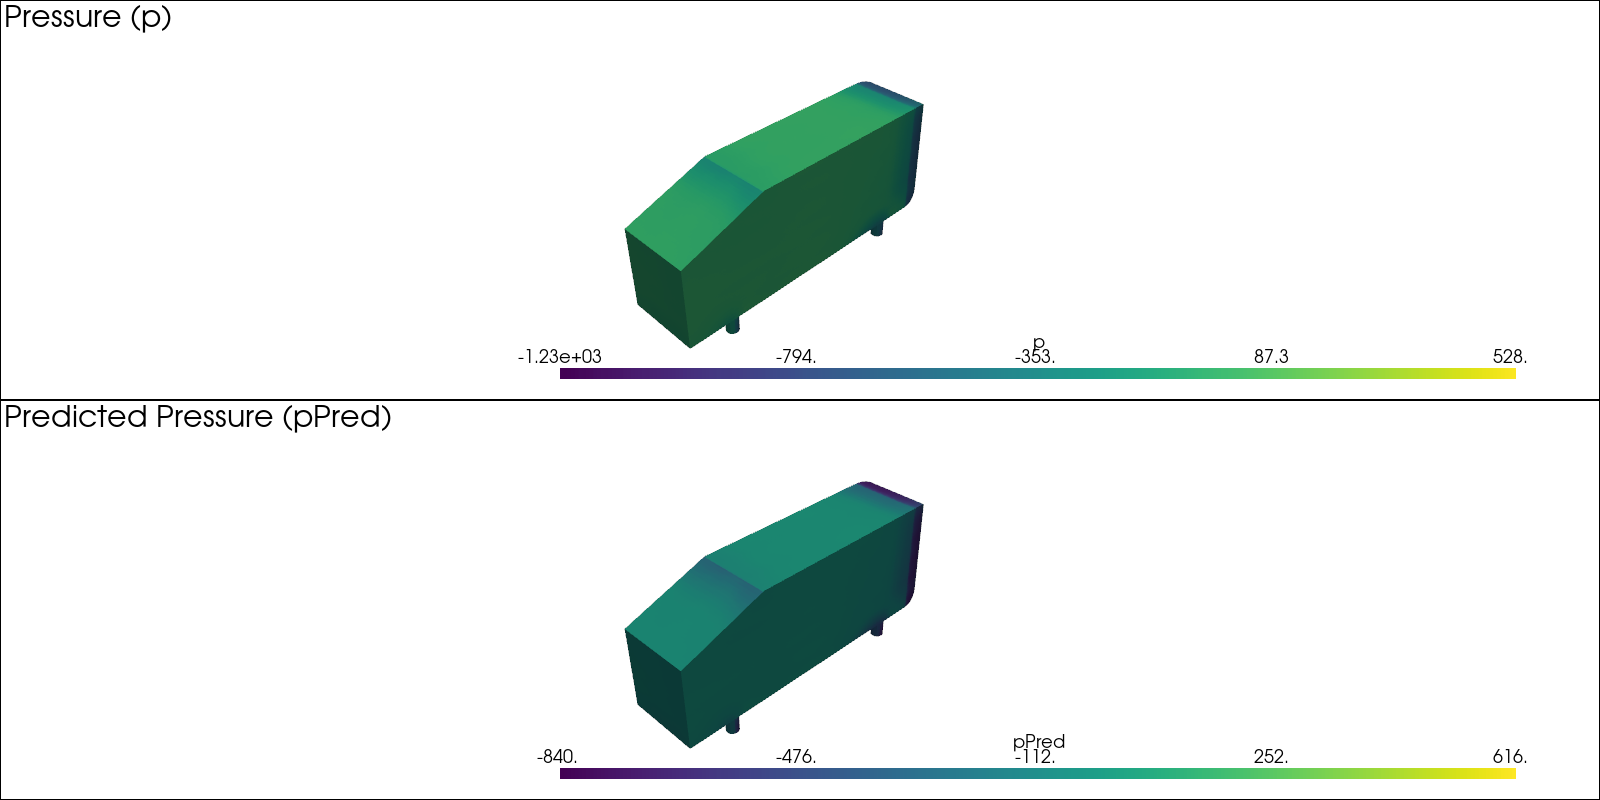

In [8]:
##### import pyvista as pv

# Start virtual framebuffer for off-screen rendering (useful in Jupyter/containers)
pv.start_xvfb()

# Read the VTP mesh
mesh = pv.read("/workspace/python/source_code/DoMINO/mesh_predictions_surf_final1/boundary_119_predicted.vtp")
print("Available cell data keys:", mesh.cell_data.keys())

# Create a Plotter with 2 vertical subplots
plotter = pv.Plotter(shape=(2, 1), window_size=[1600, 800], off_screen=True)

# Plot 'p' (ground truth or reference)
plotter.subplot(0, 0)
plotter.add_text("Pressure (p)", font_size=12)
plotter.add_mesh(mesh, scalars="p", show_edges=False)

# Plot 'pPred' (predicted pressure)
plotter.subplot(1, 0)
plotter.add_text("Predicted Pressure (pPred)", font_size=12)
plotter.add_mesh(mesh, scalars="pPred", show_edges=False)

# Show both subplots
plotter.show(jupyter_backend='static')

In [ ]:
import os
os._exit(00)